_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Student names: *Harry Antony (MSc NIP), Nishad Singhi (MSc NIP)*

# Coding Lab 1

Download the data file ```nda_ex1.csv``` from ILIAS and save it in a subfolder ```../data/```.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
import scipy as sp
import itertools as it
sns.set_style('whitegrid')
%matplotlib inline


## Load data

In [2]:
Fs = 30000     # sampling rate of the signal in Hz
dt = 1/Fs
gain = .5      # gain of the signal
x = pd.read_csv('../data/nda_ex_1.csv', header=0, names=('Ch1', 'Ch2', 'Ch3', 'Ch4'))  

## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filterSignal()```. A typical choice for this task would be a butterworth filter. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


In [89]:
def filterSignal(x, Fs, low, high):
    # Filter raw signal
    #   y = filterSignal(x, Fs, low, high) filters the signal x. Each column in x is one
    #   recording channel. Fs is the sampling frequency. low and high specify the passband in Hz.
    #   The filter delay is compensated in the output y.

    # filter
    b, a = signal.butter(5, (low, high), 'bandpass', fs=Fs)

    filtered_columns = {}
    for column in x.columns:
        filtered_columns[column] = signal.filtfilt(b, a, x[column])
        
    y = pd.DataFrame(filtered_columns)

    return y

In [88]:
xf = filterSignal(x, Fs, 500, 4000)

{'Ch1': array([-3.22589402, -4.38275482, -9.01367995, ..., 33.72917501,
       17.82856265, -2.43070168]), 'Ch2': array([ -5.66091318,  -3.20297697,  -1.90225477, ..., -16.44799337,
        -9.58619034,   5.63107891]), 'Ch3': array([-2.09290817,  4.02287414,  6.36821989, ..., -1.95588094,
       -0.26466757,  5.76335039]), 'Ch4': array([ -5.70970903,  -8.69924685, -12.15041059, ..., -10.62740243,
        -5.6351993 ,   3.56403882])}


,Ch1,Ch2,Ch3,Ch4
0,-3.225894,-5.660913,-2.092908,-5.709709
1,-4.382755,-3.202977,4.022874,-8.699247
2,-9.013680,-1.902255,6.368220,-12.150411
3,-18.875937,-2.854287,2.734572,-16.866847
4,-33.022144,-6.674506,-6.564842,-23.568985


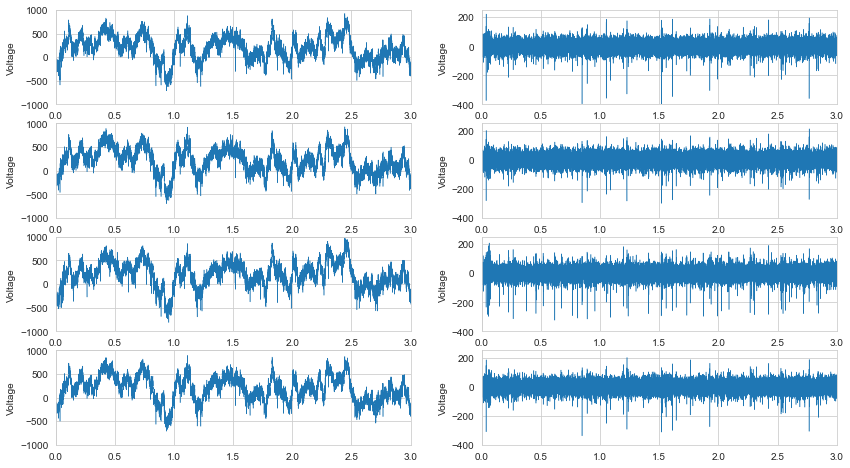

In [5]:
plt.figure(figsize=(14, 8))

T = 100000
t = np.arange(0,T) * dt 

for i, col in enumerate(xf):
    plt.subplot(4,2,2*i+1)
    plt.plot(t,x[col][0:T],linewidth=.5)
    plt.ylim((-1000, 1000))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
    
    
    plt.subplot(4,2,2*i+2)
    plt.plot(t,xf[col][0:T],linewidth=.5)
    plt.ylim((-400, 250))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
    

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detectSpikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. Plot the threshold. Are the detected time points well aligned with peaks in the signal?

*Grading: 3 pts*

In [100]:
def detectSpikes(x,Fs):
    # Detect spikes
    # s, t = detectSpikes(x,Fs) detects spikes in x, where Fs the sampling
    #   rate (in Hz). The outputs s and t are column vectors of spike times in
    #   samples and ms, respectively. By convention the time of the zeroth
    #   sample is 0 ms.
    
    N = 4
    
    all_peaks_idx = []
    
    for column in range(np.shape(x)[1]):
        x_column = x[:, column]
        dev = np.absolute(x_column - np.mean(x_column)) / 0.6745
        sigma = np.median(dev)
        threshold = N*sigma    
        
        all_peaks_idx += signal.find_peaks(-1*x_column, height=threshold)[0].tolist()
    
    s_all = np.sort(np.unique(all_peaks_idx))
    peaks_after_removing_duplicates = np.concatenate((np.array([True]), np.diff(s_all)>10))
    s = s_all[peaks_after_removing_duplicates==1]
    t = s/Fs

    return (s, t)

In [101]:
T = xf.shape[0]
s, t = detectSpikes(xf.to_numpy(),Fs)

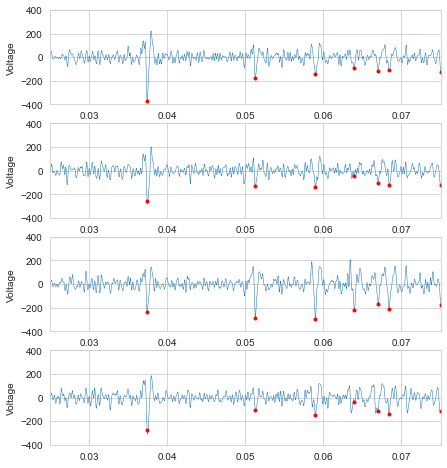

In [104]:
plt.figure(figsize=(7, 8))

tt = np.arange(0,T) * dt 

for i, col in enumerate(xf):
    plt.subplot(4,1,i+1)
    plt.plot(tt,xf[col],linewidth=.5)
    plt.plot(tt[s],xf[col][s],'r.')
    plt.ylim((-400, 400))
    plt.xlim((0.025,0.075))
    plt.ylabel('Voltage')

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extractWaveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [109]:
def extractWaveforms(x, s):
# Extract spike waveforms.
#   w = extractWaveforms(x, s) extracts the waveforms at times s (given in
#   samples) from the filtered signal x using a fixed window around the
#   times of the spikes. The return value w is a 3d array of size
#   length(window) x #spikes x #channels.
    
    length_win = 30
    num_channels = 4
    num_spikes = np.size(s)
    
    w = np.zeros((length_win, num_spikes, num_channels))

    for i in range(num_spikes):
        sample = s[i]
        w[:, i, :] = x[sample-10:sample+20, :]
        
    return w
    

Plot first 100 spike waveforms

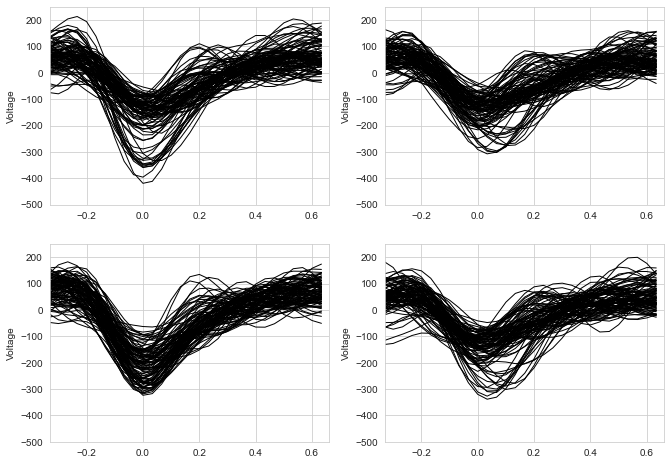

In [65]:
t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))

for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,1:100,i],'k', linewidth=1)
    plt.ylim((-500, 250))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')


Plot largest 100 spike waveforms

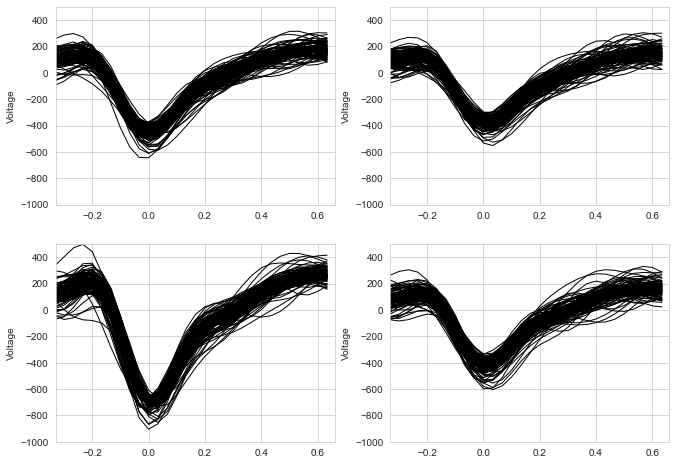

In [66]:
idx = np.argsort(np.min(np.min(w,axis=2),axis=0))


t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))
for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,idx[0:100],i],'k', linewidth=1)
    plt.ylim((-1000, 500))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')


## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extractFeatures()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


In [114]:
# w = length(window) x #spikes x #channels.

def extractFeatures(w):
# Extract features for spike sorting.
#   b = extractFeatures(w) extracts features for spike sorting from the
#   waveforms in w, which is a 3d array of size length(window) x #spikes x
#   #channels. The output b is a matrix of size #spikes x #features.
#   The implementation should do PCA on the waveforms of each channel
#   separately and uses the first three principal components. Thus, we get
#   a total of 12 features. Also, the varianced explained by the 3 features per channel
#   should be computed.
    
    num_spikes = np.shape(w)[1]
    num_features_each_channel = 3
    num_channels = np.shape(w)[2]
    num_total_features = num_features_each_channel*num_channels
    
    all_channels_extracted_features = []
    for channel in range(num_channels):
        all_spikes = w[:, :, channel].T
        pca = PCA(num_features_each_channel)
        pca.fit(all_spikes)
        
        all_channels_extracted_features.append(pca.transform(all_spikes))
        
        print("Channel = ", channel)
        print("% variance explained by the first {} PCs = {}".format(num_features_each_channel, pca.explained_variance_ratio_*100))
        print("----------------")
        
    b = np.hstack(all_channels_extracted_features)
    
    return b

In [115]:
b = extractFeatures(w)

Channel =  0
% variance explained by the first 3 PCs = [87.83035606  5.53231802  3.67452113]
----------------
Channel =  1
% variance explained by the first 3 PCs = [78.3088519   9.67373634  5.74678986]
----------------
Channel =  2
% variance explained by the first 3 PCs = [90.48794025  4.84162213  2.08165482]
----------------
Channel =  3
% variance explained by the first 3 PCs = [72.91559542 17.24712082  5.37867299]
----------------


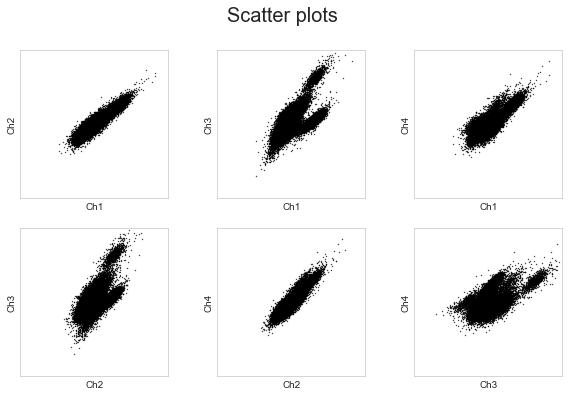

In [76]:
plt.figure(figsize=(10, 6))
plt.suptitle('Scatter plots',fontsize=20)

idx = [0, 3, 6, 9]
p = 1
labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,p, aspect='equal')
        plt.plot(b[:,idx[i]],b[:,idx[j]],'.k', markersize=.7) 
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-1500,1500))
        plt.ylim((-1500,1500))
        ax.set_xticks([])
        ax.set_yticks([])
        p = p+1

In [ ]:
np.save('../data/nda_ex_1_features',b)
np.save('../data/nda_ex_1_spiketimes',s)
np.save('../data/nda_ex_1_waveforms',w)